In [ ]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)

SpikeInterface version: 0.103.2


In [97]:
def extract_datetime(path):
    """
    Extract datetime from a file path containing datetime string in format YYMMDD_HHMMSS.
    
    Parameters
    ----------
    path : str
        Path to extract datetime from.
    
    Returns
    -------
    datetime
        Extracted datetime object. Returns datetime.min if pattern not found.
    """
    m = re.search(r'(\d{6}_\d{6})', path)
    if m:
        return datetime.strptime(m.group(1), "%y%m%d_%H%M%S")
    return datetime.min

In [98]:
# Set base path and load recording data
# basepath = "/local/workdir/ys2375/PreprocessPipeline/data/hp18_day86"
basepath = "/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03"
dataPath = glob.glob(basepath + '/*/amplifier.dat')
dataPath = sorted(dataPath, key=extract_datetime)
display(dataPath)

# Load channel map
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]

['/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat']

## Mapping channel

[]


(<matplotlib.collections.PolyCollection at 0x7f4b2e576790>, None)

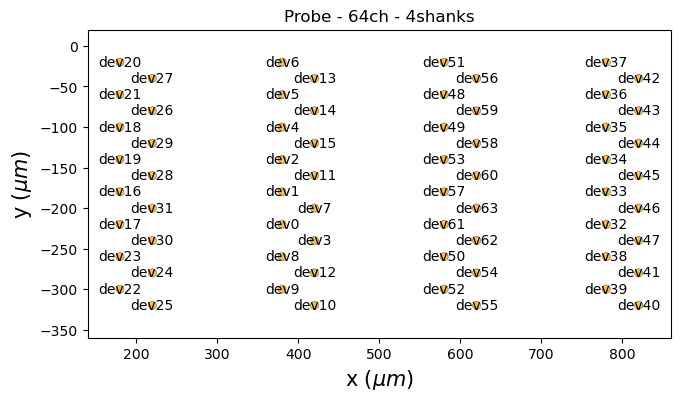

In [99]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1
bad_ch_ids = np.where(chanMapmat['connected'][:,0]==0)[0]
print(bad_ch_ids)

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(8,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

## Concatenate .dat

In [100]:
# Sampling frequency and channel count
fs = 20000
num_channels = len(probe.device_channel_indices)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)

/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat
/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat


In [101]:
# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(basepath) / file_name

# Write concatenated binary recording with desired filename
si.write_binary_recording(
    recording,
    file_paths=str(final_dat_path),
    add_file_extension=False,
    verbose=True,
    **job_kwargs
)
print(f"Saved to: {final_dat_path}")

write_binary_recording 
engine=process - n_jobs=512 - samples_per_chunk=40,000 - chunk_memory=4.88 MiB - total_memory=2.44 GiB - chunk_duration=2.00s


write_binary_recording (workers: 512 processes): 100%|██████████| 6065/6065 [00:22<00:00, 273.78it/s]



Saved to: /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_day03.dat


## Preprocessing
### Set probe
### Remove bad channel
### Bandpass filter (500 - 8000 Hz)
### Common median filter 
### Artifact removal

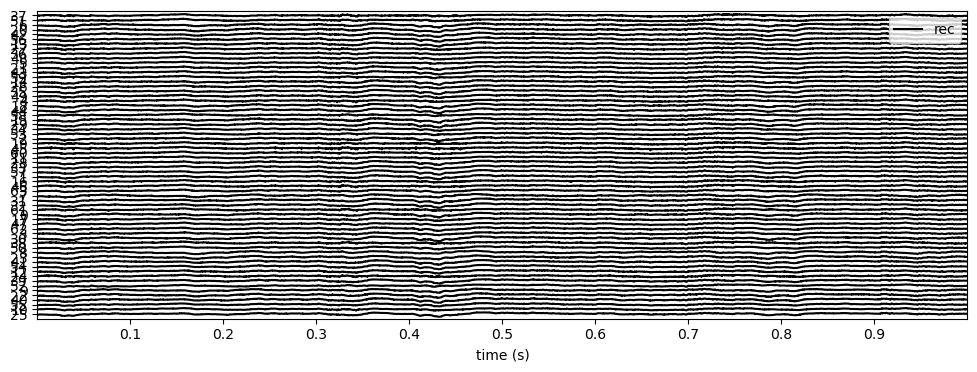

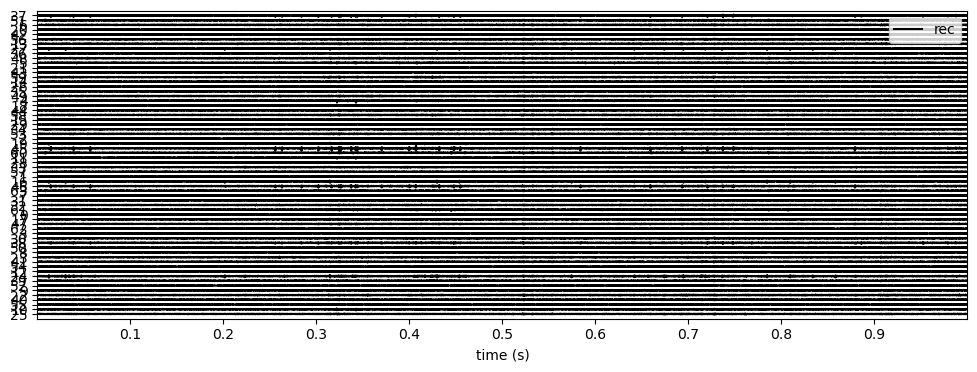

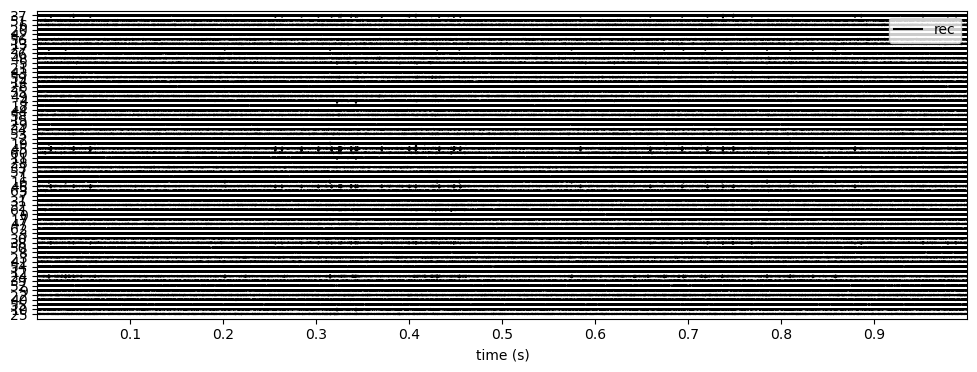

In [102]:
# Set probe and remove bad channels
recording_raw = recording.set_probe(probe, group_mode='by_shank')
recording_raw = recording_raw.remove_channels(remove_channel_ids=bad_ch_ids)

# Plot parameters
tmin = 0
twind = 1
segment_index = 0

# Plot raw traces
sw.plot_traces(
    recording_raw,
    channel_ids=recording_raw.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

# Apply bandpass filter (500-8000 Hz)
recording_f = spre.bandpass_filter(recording_raw, freq_min=500, freq_max=8000)
sw.plot_traces(
    recording_f,
    channel_ids=recording_f.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

# Apply common median reference (local)
recording_cmr = spre.common_reference(
    recording_f,
    reference='local',
    local_radius=[50, 200],
    operator='median'
)
sw.plot_traces(
    recording_cmr,
    channel_ids=recording_cmr.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(12, 4)
)

In [ ]:
def detect_high_amplitude_artifacts(
    recording, 
    group_property: str = "group",
    estimate_windows: int = 50,        # Number of random windows used to estimate per-shank noise scale
    estimate_window_s: float = 1.0,    # Duration (s) of each estimation window
    safety_factor_amp: float = 20,     # Multiplier on noise scale (MAD→σ) to set amplitude threshold
    seed: int = 0,                     # RNG seed for reproducible window sampling

    chunk_s: float = 5.0,              # Chunk duration (s) for scanning the full recording
    dead_time_ms: float = 100.0,       # Refractory (ms) to merge nearby triggers from the same shank
    n_jobs: int = -1                   # Number of parallel workers for chunk scanning (joblib semantics)
):
    """
    Detect large-amplitude movement/lick artifacts and return trigger frames per shank.
    All steps (threshold estimation, worker definition, parallel scanning, aggregation) are
    performed inside this single function.

    Parameters
    ----------
    recording : si.BaseRecording (or compatible)
        Single-segment recording extractor. Must support:
        - get_sampling_frequency()
        - get_total_samples()
        - get_traces(start_frame, end_frame, return_in_uV=True)
        - get_channel_ids()
        - get_property(name) -> per-channel array
        - select_channels(channel_ids=...)
    group_property : str, default "group"
        Channel property that encodes shank/cluster membership. If missing or invalid,
        all channels are treated as a single shank.
    estimate_windows : int, default 50
        Number of random time windows used to estimate a robust amplitude scale per shank.
        Larger values give more stable thresholds at the cost of additional I/O.
    estimate_window_s : float, default 1.0
        Duration (in seconds) of each estimation window.
    safety_factor_amp : float, default 20
        Amplitude threshold = (robust sigma estimate) × safety_factor_amp.
        Increase to be more conservative; decrease to detect more events.
    seed : int, default 0
        Random seed for selecting estimation windows.

    chunk_s : float, default 5.0
        Length (in seconds) of each scanning chunk. Smaller chunks reduce memory use but
        increase scheduling overhead.
    dead_time_ms : float, default 100.0
        Minimum spacing (per shank) between reported triggers. Subsequent violations
        within this window are suppressed.
    n_jobs : int, default -1
        Number of parallel workers used by joblib. -1 uses all available cores.

    Returns
    -------
    dict[int, list[int]]
        Mapping shank_id -> sorted list of trigger frame indices on the global timeline.

    Notes
    -----
    - The robust sigma is computed from the per-time median across channels of the shank,
      using MAD→σ (1.4826 × median(|x - median(x)|)).
    - Thresholding is applied to |median_across_shank_channels| to be robust to polarity and noise.
    - This function assumes a single segment (asserted at start).
    """
    
    def _worker_scan_chunk_inner(start_frame, end_frame, thresholds_dict, shank_to_inds):
        # Load traces in microvolts for the time window [start_frame, end_frame)
        X = recording.get_traces(
            start_frame=start_frame, 
            end_frame=end_frame, 
            return_in_uV=True
        ).astype(np.float32)

        # For each shank, test the absolute median across its channels against the shank threshold
        candidates = {}
        for sid, ch_inds in shank_to_inds.items():
            if ch_inds.size == 0 or sid not in thresholds_dict:
                continue

            th_amp = thresholds_dict[sid]
            
            # Median across channels for each timepoint (robust to per-channel outliers)
            m = np.median(X[:, ch_inds], axis=1)
            
            violation_mask = np.abs(m) > th_amp
            violation_inds = np.flatnonzero(violation_mask)

            if violation_inds.size > 0:
                # Convert local indices to global frame indices
                candidates[sid] = violation_inds + start_frame
        return candidates

    # ----------------------------------------------------
    
    assert recording.get_num_segments() == 1, "Single segment only supported"
    
    sf = recording.get_sampling_frequency()
    T = recording.get_total_samples()
    dead_time_samp = int(dead_time_ms * 1e-3 * sf)

    ch_ids = recording.get_channel_ids()
    try:
        # Per-channel shank ids (same order/length as ch_ids)
        shank_ids = np.asarray(recording.get_property(group_property))
    except Exception:
        # Fallback: all channels belong to shank 0
        shank_ids = np.zeros(len(ch_ids), dtype=int)
    
    unique_shanks = np.unique(shank_ids)
    shank_to_inds = {int(s): np.where(shank_ids == s)[0] for s in unique_shanks}

    print(f"Detecting artifacts on {len(unique_shanks)} shanks...")

    # -------------------- threshold estimation --------------------
    print("Estimating thresholds...")
    thresholds = {}
    rng = np.random.default_rng(seed)
    W_est = int(estimate_window_s * sf)

    for sid in unique_shanks:
        idx = shank_to_inds[sid]
        if idx.size == 0:
            continue

        sub = recording.select_channels(channel_ids=ch_ids[idx])
        # Sample random, nonoverlapping starting points for estimation windows
        starts = rng.integers(0, max(1, T - W_est - 1), size=estimate_windows)
        pool_abs = []
        
        for s in starts:
            # Load window and compute time-wise median across channels
            X_est = sub.get_traces(start_frame=int(s), end_frame=int(s+W_est), return_in_uV=True).astype(np.float32).T
            m = np.median(X_est, axis=0)
            m = m - np.median(m)
            pool_abs.append(np.abs(m))
        
        if not pool_abs:
            # Degenerate case: set an extremely high threshold to avoid false positives
            thresholds[int(sid)] = 1e6
            continue
            
        abs_vals = np.concatenate(pool_abs)
        sigma = 1.4826 * np.median(abs_vals)   # MAD → σ
        thresholds[int(sid)] = sigma * safety_factor_amp

    # -------------------- scanning --------------------
    print(f"Scanning recording using backend='threading' (n_jobs={n_jobs})...")
    chunk_len = int(chunk_s * sf)
    chunks = []
    beg = 0
    while beg < T:
        end = min(T, beg + chunk_len)
        chunks.append((beg, end))
        beg = end

    # Parallel chunk scan; returns a list of dicts: shank_id -> trigger frames (local→global)
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(_worker_scan_chunk_inner)(
            start, end, thresholds, shank_to_inds
        ) 
        for start, end in chunks
    )

    # -------------------- aggregation & dead-time merge --------------------
    all_candidates = {int(s): [] for s in unique_shanks}
    for res in results:
        for sid, inds in res.items():
            all_candidates[sid].append(inds)

    final_triggers = {}

    for sid in unique_shanks:
        if not all_candidates[sid]:
            final_triggers[sid] = []
            continue
            
        candidates = np.concatenate(all_candidates[sid])
        candidates.sort()
        
        # Enforce dead time on a per-shank basis
        filtered = []
        last_trig = -dead_time_samp * 2

        for t in candidates:
            if t - last_trig > dead_time_samp:
                filtered.append(int(t))
                last_trig = t
        
        final_triggers[sid] = filtered

    print("Done.")
    return final_triggers


def remove_artifacts_per_shank(
    recording_in: si.BaseRecording,
    artifact_per_shank: dict[int, list[int]],
    group_property: str = "group",
    ms_before: float = 0.5,        # Window start relative to trigger (ms; positive values look back in time)
    ms_after: float = 3.0,         # Window end relative to trigger (ms; positive values look forward in time)
    mode: str = "cubic",           # Interpolation strategy: 'cubic' | 'linear' | 'mean' (SI >= 0.98)
):
    """
    Apply `spre.remove_artifacts` independently per shank, then stitch channels back together.

    Parameters
    ----------
    recording_in : si.BaseRecording
        Single-segment input recording extractor.
    artifact_per_shank : dict[int, list[int]]
        Mapping shank_id -> list of trigger frames (global timeline) to remove.
        Triggers are de-duplicated and sorted inside the function.
    group_property : str, default "group"
        Channel property that encodes shank/cluster membership. If absent or invalid,
        all channels are treated as one shank.
    ms_before : float, default 0.5
        Time in milliseconds before each trigger to include in the artifact window.
    ms_after : float, default 3.0
        Time in milliseconds after each trigger to include in the artifact window.
    mode : {'cubic','linear','mean'}, default 'cubic'
        Artifact replacement method (as implemented in `spre.remove_artifacts`).
        - 'cubic'/'linear': interpolate across the masked window
        - 'mean' (SI >= 0.98): replace with local mean

    Returns
    -------
    recording_clean : si.BaseRecording
        Recording with artifacts removed, channels re-aggregated in a deterministic order.
    details : dict
        Per-shank metadata including n_triggers, window settings, mode, and channel_ids.

    Notes
    -----
    - Shank order is deterministic: sorted by the first channel index of each shank, then
      original channel order within each shank is preserved.
    - The original `group_property` is re-applied to the aggregated recording (best-effort).
    """
    assert recording_in.get_num_segments() == 1, "single-segment only"

    sf = recording_in.get_sampling_frequency()
    ch_ids = recording_in.get_channel_ids()

    # --- group (shank) assignment ---
    try:
        shank_ids = np.asarray(recording_in.get_property(group_property))
        if shank_ids.shape[0] != len(ch_ids):
            raise ValueError("group_property length mismatch")
    except Exception:
        # If missing, put all channels into one shank
        shank_ids = np.zeros(len(ch_ids), dtype=int)

    # Build shank -> channel indices (preserve original channel order)
    shank_to_inds = {int(s): np.where(shank_ids == s)[0] for s in np.unique(shank_ids)}
    # Determine deterministic shank order as they appear along channels
    ordered_sids = sorted(shank_to_inds.keys(), key=lambda s: (shank_to_inds[s][0] if shank_to_inds[s].size else 1e18))

    cleaned_subs = []
    details = {}

    for sid in ordered_sids:
        idx = shank_to_inds[sid]
        if idx.size == 0:
            continue

        # Sub-recording for this shank (keeps properties)
        sh_ch_ids = ch_ids[idx]
        sub_rec = recording_in.select_channels(channel_ids=sh_ch_ids)

        # Triggers for this shank (frames). Deduplicate & sort.
        trig = artifact_per_shank.get(int(sid), [])
        if trig:
            trig = np.unique(np.asarray(trig, dtype=np.int64)).tolist()

        if trig:
            # Apply artifact removal on this shank only
            sub_clean = spre.remove_artifacts(
                sub_rec,
                list_triggers=trig,     # frames on the full recording timeline
                ms_before=ms_before,
                ms_after=ms_after,
                mode=mode,
            )
            details[int(sid)] = {
                "n_triggers": len(trig),
                "ms_before": ms_before,
                "ms_after": ms_after,
                "mode": mode,
                "channel_ids": sh_ch_ids.tolist(),
            }
        else:
            # No triggers -> passthrough
            sub_clean = sub_rec
            details[int(sid)] = {
                "n_triggers": 0,
                "ms_before": ms_before,
                "ms_after": ms_after,
                "mode": mode,
                "channel_ids": sh_ch_ids.tolist(),
            }

        cleaned_subs.append(sub_clean)

    # Aggregate channels back (keeps original order by our shank ordering + in-shank order)
    recording_clean = si.aggregate_channels(cleaned_subs)

    # Re-apply group property on the aggregated recording to preserve downstream behavior
    try:
        # Build back the group vector in the same channel order as recording_clean
        agg_ch_ids = recording_clean.get_channel_ids()
        # Map original channel id -> group
        gid_map = {int(ch_ids[i]): int(shank_ids[i]) for i in range(len(ch_ids))}
        agg_groups = [gid_map[int(ch)] for ch in agg_ch_ids]
        recording_clean.set_channel_property(agg_ch_ids, group_property, agg_groups)
    except Exception:
        # Best-effort: failure here is non-fatal for artifact removal
        pass

    return recording_clean, details


In [114]:
triggers = detect_high_amplitude_artifacts(
    recording_f,
    group_property="group",   
    estimate_windows=50,       
    safety_factor_amp=30,      
    chunk_s=100,               
    dead_time_ms=50.0,        
    n_jobs=-1                  
)

Detecting artifacts on 4 shanks...
Estimating thresholds...
Scanning recording using backend='threading' (n_jobs=-1)...
Scanning recording using backend='threading' (n_jobs=-1)...
Done.
Done.


In [115]:
ch_ids= recording_f.get_channel_ids()
try:
    shank_ids = np.asarray(recording_f.get_property('group'))
    if shank_ids.shape[0] != len(ch_ids):
        raise ValueError("group_property length mismatch")
except Exception:
    # If missing, put all channels into one shank
    shank_ids = np.zeros(len(ch_ids), dtype=int)

# Build shank -> channel indices (preserve original channel order)
shank_to_inds = {int(s): np.where(shank_ids == s)[0] for s in np.unique(shank_ids)}
# Determine deterministic shank order as they appear along channels
ordered_sids = sorted(shank_to_inds.keys(), key=lambda s: (shank_to_inds[s][0] if shank_to_inds[s].size else 1e18))

In [116]:
recording_clean, info = remove_artifacts_per_shank(
    recording_in=recording_cmr,              
    artifact_per_shank=triggers,   
    group_property="group",
    ms_before=1,
    ms_after=1,
    mode="cubic",
)

In [117]:
def plot_traces_around_ttl_compare(
    recording_before,
    recording_after,
    ttl_times,
    *,
    before_ms: float = 5.0,
    after_ms: float = 5.0,
    units: str = "s",              # 's' or 'frames'
    segment_index: int = 0,
    channel_ids=None,              # if None, use all channels in 'recording_after' (must match before)
    order_channel_by_depth: bool = True,
    show_channel_ids: bool = True,
    color_groups: bool = False,
    figsize: tuple = (8, 4),
    n_max: int | None = None,      # limit how many TTLs to plot (None = all)
):
    """
    For each TTL, plot two figures back-to-back:
      1) BEFORE  (recording_before)
      2) AFTER   (recording_after)
    with the exact same time window and channel ordering.
    """
    # basic checks
    assert recording_before.get_num_segments() > segment_index, "segment_index out of range (before)"
    assert recording_after.get_num_segments()  > segment_index, "segment_index out of range (after)"

    sf_bef = recording_before.get_sampling_frequency()
    sf_aft = recording_after.get_sampling_frequency()
    if abs(sf_bef - sf_aft) > 1e-6:
        raise ValueError(f"Sampling frequency mismatch: before={sf_bef}, after={sf_aft}")

    sf = sf_bef
    total_time = recording_after.get_num_frames(segment_index=segment_index) / sf

    # TTL -> seconds
    ttl_times = np.asarray(ttl_times, dtype=float)
    if units == "frames":
        ttl_times = ttl_times / sf

    # window
    b = before_ms / 1000.0
    a = after_ms  / 1000.0

    # channels
    if channel_ids is None:
        channel_ids = recording_after.get_channel_ids()
    # sanity: ensure same channel ids are present in 'before'
    ch_b = set(map(int, recording_before.get_channel_ids()))
    for c in channel_ids:
        if int(c) not in ch_b:
            raise ValueError(f"Channel {c} not present in 'recording_before'")

    # pick subset to plot
    if n_max is not None and len(ttl_times) > n_max:
        # uniform subsample for a quick overview
        idxs = np.linspace(0, len(ttl_times) - 1, n_max, dtype=int)
        ttl_times = ttl_times[idxs]

    for t0 in ttl_times:
        # clamp
        tmin = max(0.0, t0 - b)
        tmax = min(total_time, t0 + a)
        if tmax <= tmin:
            continue

        # BEFORE
        sw.plot_traces(
            recording_before,
            channel_ids=channel_ids,
            order_channel_by_depth=order_channel_by_depth,
            show_channel_ids=show_channel_ids,
            time_range=[tmin, tmax],
            segment_index=segment_index,
            color_groups=color_groups,
            figsize=figsize,
        )

        # AFTER
        sw.plot_traces(
            recording_after,
            channel_ids=channel_ids,
            order_channel_by_depth=order_channel_by_depth,
            show_channel_ids=show_channel_ids,
            time_range=[tmin, tmax],
            segment_index=segment_index,
            color_groups=color_groups,
            figsize=figsize,
        )

In [118]:
triggers.keys()

dict_keys([0, 1, 2, 3])

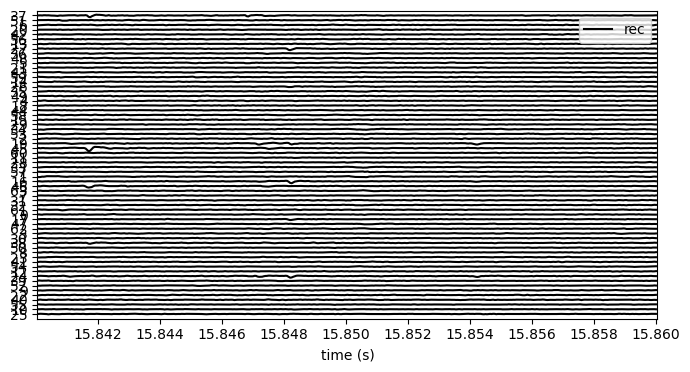

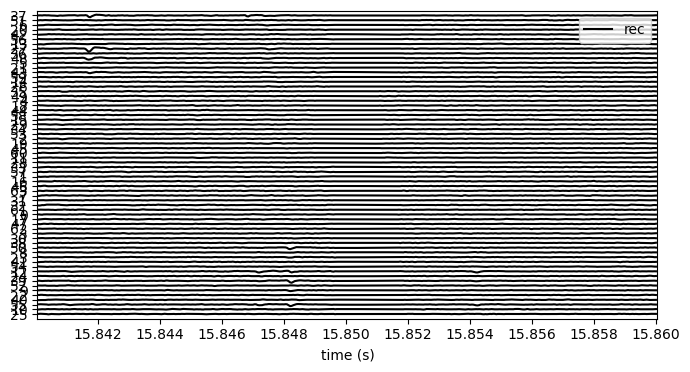

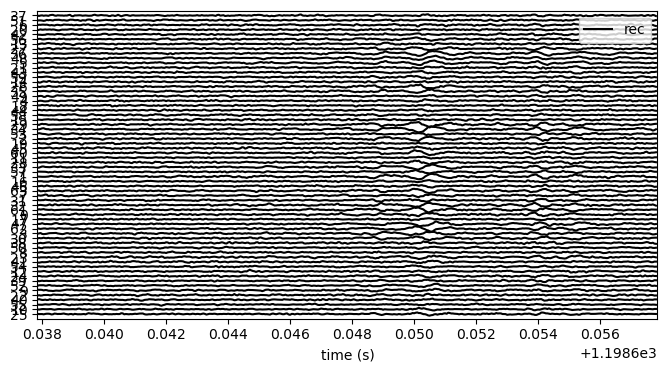

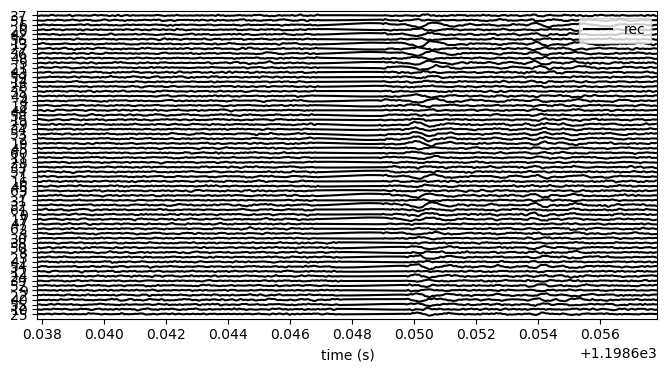

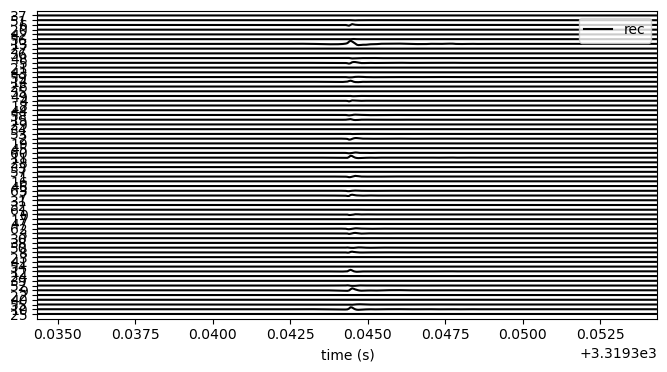

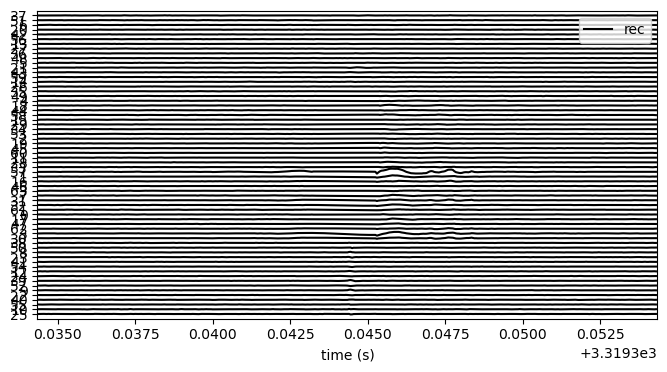

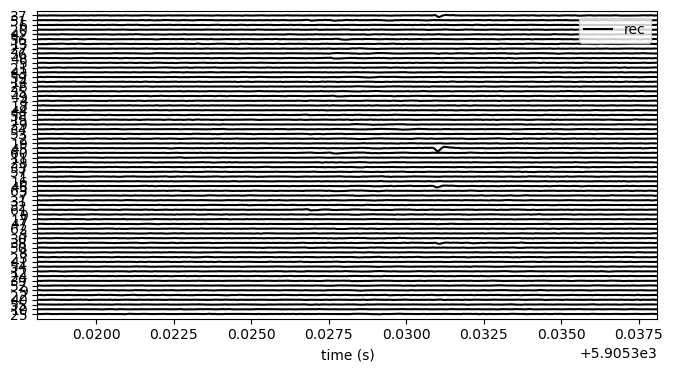

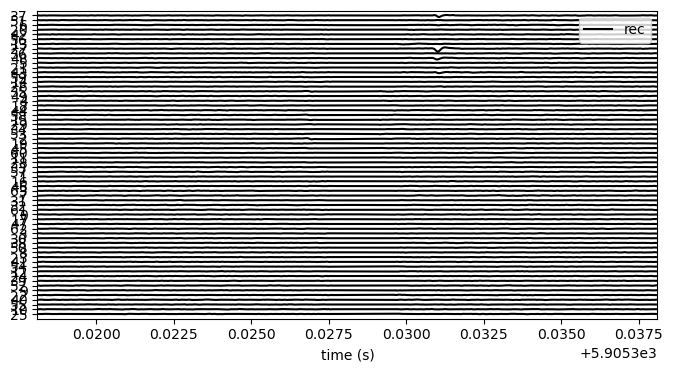

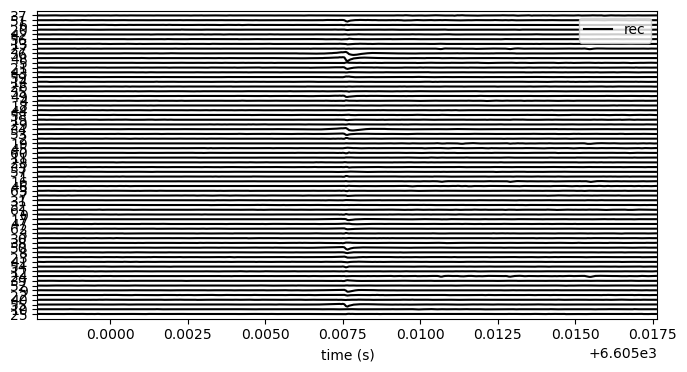

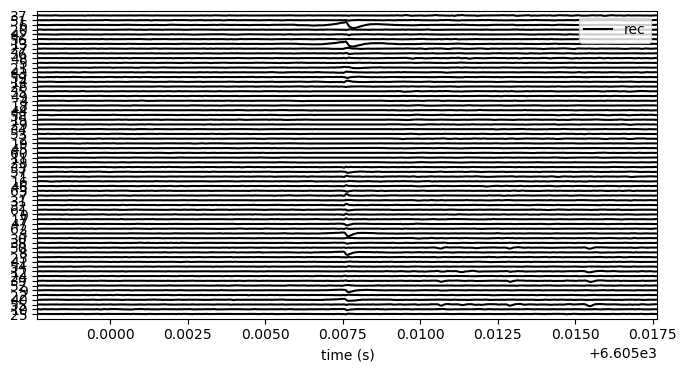

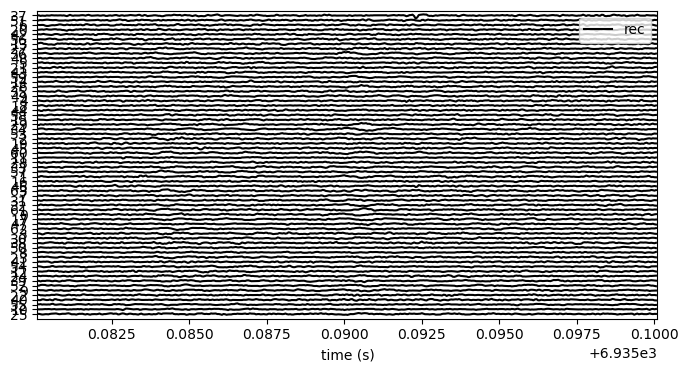

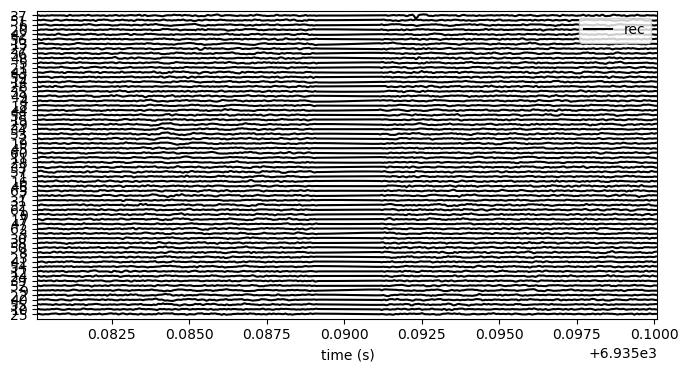

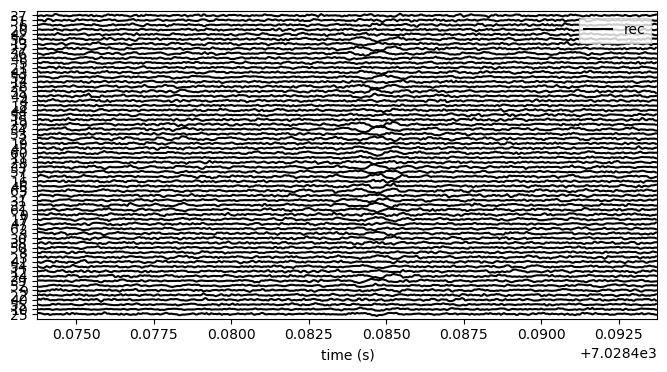

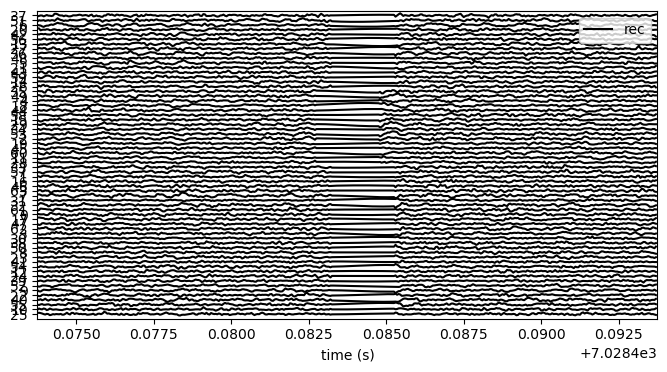

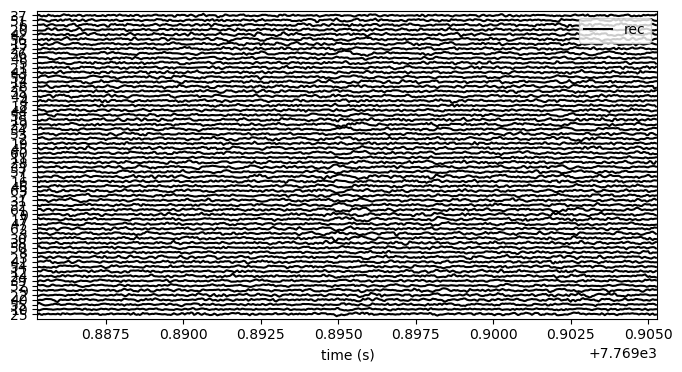

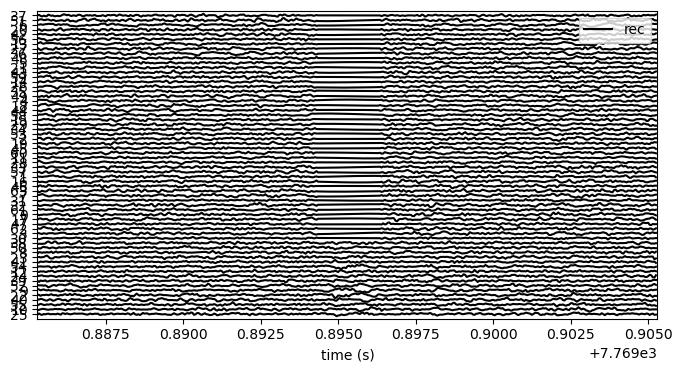

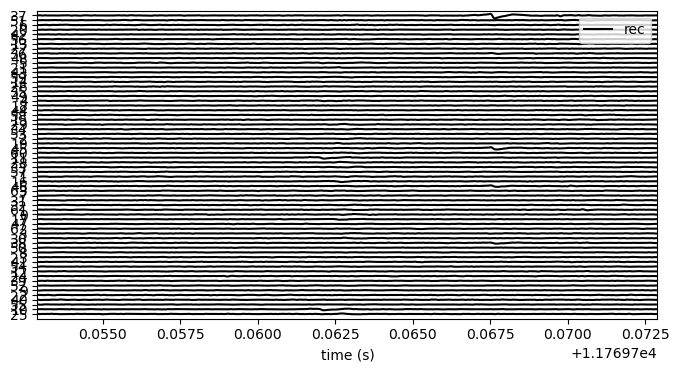

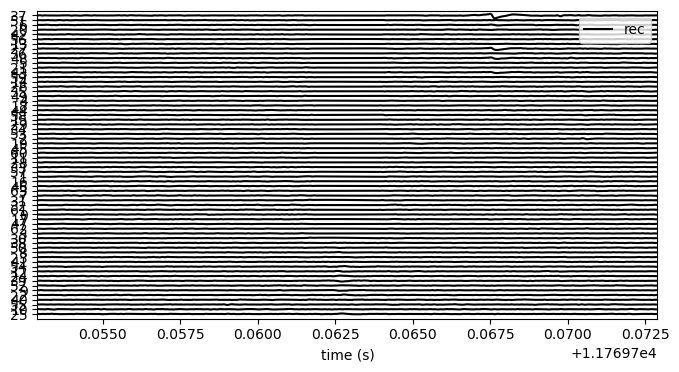

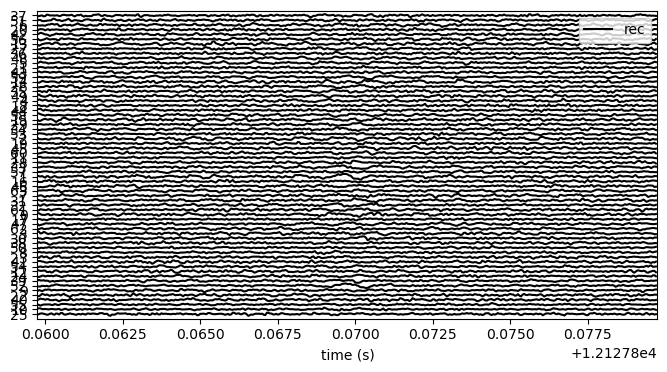

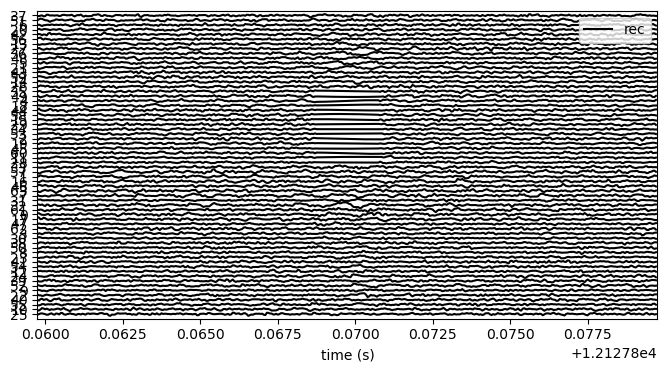

In [119]:
plot_traces_around_ttl_compare(
    recording_before=recording_cmr,
    recording_after=recording_clean,
    ttl_times=triggers[2],  
    before_ms=10.0,
    after_ms=10.0,
    units="frames",
    segment_index=0,
    channel_ids=recording_cmr.get_channel_ids(),  # 同じ順序で
    n_max=10,                                     # 多い時は上限
)


## Spike Sorting

In [120]:
params = ss.get_default_sorter_params('kilosort4')
params

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'batch_downsampling': 1,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_neighbors': 10,
 'cluster_downsampling': 1,
 'max_cluster_subset': 25000,
 'x_centers': None,
 'cluster_init_seed': 5,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correctio

In [ ]:
# Waveform extraction and spike detection parameters
params['nt'] = 41                              # Number of timepoints per waveform (≈2 ms at 30 kHz; adjust with sampling rate)
params['nblocks'] = 0                          # Number of depth blocks for drift correction (0 disables drift correction)
params['batch_size'] = 120000                  # Number of samples per processing batch (larger improves drift estimation)
params['Th_single_ch'] = 4                     # Single-channel detection threshold (not a core Kilosort4 parameter)
params['Th_universal'] = 8                     # Universal template detection threshold (lower by 1–2 to detect more spikes)
params['Th_learned'] = 8                       # Learned template detection threshold (adjust similarly if spikes are missed)

# Template and clustering parameters
params['max_peels'] = 150                      # Maximum number of spike extraction iterations (internal limit, rarely changed)
params['nearest_templates'] = 150              # Number of nearest templates to consider for matching (≤ total channels)
params['n_templates'] = 10                     # Number of tracked templates (not a main Kilosort4 tuning parameter)
params['dmin'] = 20                            # Minimum vertical distance between template centers (µm)
params['dminx'] = 40                           # Minimum horizontal distance between template centers (µm)
params['nearest_chans'] = 12                   # Number of nearest channels used for spike detection and assignment

# Channel geometry and whitening parameters
params['max_channel_distance'] = 120           # Max distance for spatial search (used by SpikeInterface wrapper)
params['x_centers'] = 8                        # Number of x-position centers for template placement (≈200–300 µm spacing)
params['whitening_range'] = 24                 # Whitening range in channels (not commonly adjusted)
params['highpass_cutoff'] = 500                # High-pass filter cutoff frequency (Hz; part of preprocessing filter)

# Processing and optimization parameters
params['do_CAR'] = False                       # Disable common average referencing (already applied externally)
params['acg_threshold'] = 0.5                  # Autocorrelogram threshold for cluster quality (wrapper-level QC)
params['ccg_threshold'] = 0.0                  # Cross-correlogram threshold for QC (wrapper-level)
params['n_jobs'] = n_jobs                      # Number of parallel jobs (SpikeInterface parallelization, not core KS4)
params['delete_recording_dat'] = False         # Keep raw .dat file after sorting
params['clear_cache'] = True                   # Clear cached data to free memory after sorting


In [ ]:
%%time
sorting = ss.run_sorter(
    sorter_name="kilosort4",
    recording=recording_clean,
    folder=basepath + '/kilosort4',
    remove_existing_folder=True,
    with_output=True,
    **params
)

 11%|█         | 215/2022 [01:25<11:49,  2.55it/s]

## Postprocessing
### Remove duplicated spikes from same cluster
### Remove redundant clusters

In [ ]:
sorting = se.read_phy(basepath + '/kilosort4/sorter_output')

In [ ]:
# Remove duplicated spikes within 0.5ms of same cluster
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)

# Create sorting analyzer for quality assessment
sa_tmp = si.create_sorting_analyzer(
    sorting_removed_duplicates,
    recording_cmr,
    format="memory",
    sparse=False
)

# Remove redundant units (putative duplicates)
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=False, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes",
    extra_outputs=True,
)
print(f"Removed {len(redundancy_info)} redundant cluster combinations.")

Removed 577 redundant combinations.


### Calculare unit features

In [ ]:
# Create or load sorting analyzer with computed features
phydir = basepath + "/kilosort4"
analyzer_folder = Path(phydir + "/analyzer_cache")

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    # Create new analyzer
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    # Compute all required features
    analyzer.compute(
        {
            "random_spikes": {},
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},
            "principal_components": {"n_components": 7, "mode": "by_channel_local"},
            "template_metrics": {},       
            "template_similarity": {},    
            "correlograms": {},
            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)

Loaded existing analyzer from disk.


### Merge clusters

In [ ]:
# Define merge criteria for clustering
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}

# Compute merge candidates based on similarity and correlograms
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 1 groups to merge.


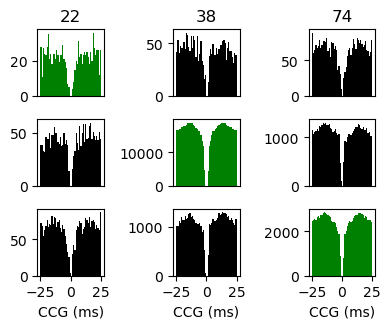

In [ ]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [ ]:
# Check which unit groups can be safely merged
mergeable = analyzer.are_units_mergeable(
    merge_unit_groups=merge_groups,
    merging_mode="soft",
    sparsity_overlap=0.5
)

# Filter to only safely mergeable groups
merge_groups = [g for g, ok in mergeable.items() if ok]
nonmerge_groups = [g for g, ok in mergeable.items() if not ok]

# Create analyzer with merged units
analyzer_merged_folder = Path(phydir + "/analyzer_cache_merged")
if analyzer_merged_folder.exists():
    try:
        shutil.rmtree(analyzer_merged_folder)
    except:
        pass

analyzer_merged = analyzer.merge_units(
    merge_unit_groups=merge_groups,
    merging_mode='soft', 
    censor_ms=0.5, 
    sparsity_overlap=0.5,
    return_new_unit_ids=False, 
    format="binary_folder", 
    folder=analyzer_merged_folder,
    overwrite=True,       
    **job_kwargs     
)

### Calcurate quality metrics and export for manual curation

In [ ]:
# Get default quality metric parameters
qm_params = sqm.get_default_qm_params()

# Compute quality metrics for all units
metrics_df = sqm.compute_quality_metrics(
    analyzer_merged,
    metric_names=['isi_violation', 'presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,  # PCs are computed above
    n_jobs=n_jobs,
    progress_bar=True
)

In [ ]:
# Export sorting results to Phy format for manual curation
phydir2 = basepath + "/kilosort4_postprocess"
export_to_phy(
    sorting_analyzer=analyzer_merged,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# Fix params.py for Phy
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Set dat_path to concatenated binary file
dat_relative_path = glob.glob(basepath + '/*.dat')[0]
content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")

# 2. Set hp_filtered flag (data is already filtered)
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"

# Write updated params back
with open(params_file, 'w') as f:
    f.write(content)

print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path}")

extract PCs (workers: 506 processes): 100%|██████████| 6065/6065 [00:15<00:00, 394.69it/s]


Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/kilosort4_postprocess/params.py
Fixed dat_path in /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/kilosort4_postprocess/params.py
Set dat_path to: /local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_day03.dat


In [ ]:
def mark_noise_clusters_from_metrics(
    phy_dir: str | Path,
    metrics_df: pd.DataFrame,
    thresholds: dict,
    backup: bool = True,
    reset_to_unsorted: bool = True,
) -> pd.DataFrame:
    """
    Update Phy's `cluster_group.tsv` to mark `group = "noise"` based on quality metrics.

    Parameters
    ----------
    phy_dir : str | Path
        Phy output folder containing `cluster_group.tsv` and `cluster_si_unit_ids.tsv`.
    metrics_df : pd.DataFrame
        DataFrame indexed by SI unit_id (or with a 'cluster_id'/'si_unit_id' column) that contains:
        - isi_violations_ratio
        - isi_violations_count
        - presence_ratio
        - snr
        - amplitude_median
    thresholds : dict
        Rules to mark noise. Supported keys (use any subset):
        - "isi_violations_ratio_gt": float  # mark noise if ratio > value
        - "isi_violations_count_gt": int    # mark noise if count > value
        - "presence_ratio_lt": float        # mark noise if presence < value
        - "snr_lt": float                   # mark noise if snr < value
        - "amplitude_median_lt": float    # mark noise if abs(amplitude_median) < value
    backup : bool
        If True, make a timestamped backup of the original TSV before overwriting.
    reset_to_unsorted : bool
        If True, reset all existing labels to "unsorted" before applying new noise labels.

    Returns
    -------
    pd.DataFrame
        The updated `cluster_group.tsv` contents as a DataFrame sorted by cluster_id.
    """
    phy_dir = Path(phy_dir)

    # --- 1) Map cluster_id (Phy) <-> si_unit_id (SpikeInterface)
    map_path = phy_dir / "cluster_si_unit_ids.tsv"
    if not map_path.exists():
        raise FileNotFoundError(f"Mapping not found: {map_path}")
    mapping = pd.read_csv(map_path, sep="\t")  # columns: cluster_id, si_unit_id
    mapping["cluster_id"] = pd.to_numeric(mapping["cluster_id"], errors="coerce").astype("Int64")
    mapping["si_unit_id"] = pd.to_numeric(mapping["si_unit_id"], errors="coerce")

    # --- 2) Normalize metrics_df to have a 'si_unit_id' column, then join mapping to get cluster_id
    df = metrics_df.copy()
    if "si_unit_id" not in df.columns and "cluster_id" not in df.columns:
        # assume index is SI unit_id
        df.index.name = "si_unit_id"
        df = df.reset_index()
    if "cluster_id" in df.columns and "si_unit_id" not in df.columns:
        # rare case: metrics already in cluster_id space
        df = df.merge(mapping, on="cluster_id", how="inner")
    else:
        df = df.merge(mapping, on="si_unit_id", how="inner")
    df["cluster_id"] = pd.to_numeric(df["cluster_id"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["cluster_id"]).set_index("cluster_id").sort_index()

    # --- 3) Build boolean masks for each rule (missing columns are treated as NaN -> False)
    # Normalize amplitude to absolute if requested
    df["_amp_abs_"] = np.abs(df["amplitude_median"]) if "amplitude_median" in df.columns else np.nan

    conds = []
    # ISI violations: both ratio AND count must exceed thresholds (AND condition)
    if ("isi_violations_ratio_gt" in thresholds and "isi_violations_count_gt" in thresholds and
        "isi_violations_ratio" in df.columns and "isi_violations_count" in df.columns):
        isi_cond = ((df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"]) &
                   (df["isi_violations_count"] > thresholds["isi_violations_count_gt"]))
        conds.append(isi_cond)
    elif "isi_violations_ratio_gt" in thresholds and "isi_violations_ratio" in df.columns:
        conds.append(df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"])
    elif "isi_violations_count_gt" in thresholds and "isi_violations_count" in df.columns:
        conds.append(df["isi_violations_count"] > thresholds["isi_violations_count_gt"])
    
    if "presence_ratio_lt" in thresholds and "presence_ratio" in df.columns:
        conds.append(df["presence_ratio"] < thresholds["presence_ratio_lt"])
    if "snr_lt" in thresholds and "snr" in df.columns:
        conds.append(df["snr"] < thresholds["snr_lt"])
    if "amplitude_median_lt" in thresholds and "_amp_abs_" in df.columns:
        conds.append(df["_amp_abs_"] < thresholds["amplitude_median_lt"])

    noise_mask = pd.concat(conds, axis=1).any(axis=1) if conds else pd.Series(False, index=df.index)

    # --- 4) Read or create cluster_group.tsv (Phy expects: cluster_id<TAB>group)
    cg_path = phy_dir / "cluster_group.tsv"
    if cg_path.exists():
        cg = pd.read_csv(cg_path, sep="\t")
        if not {"cluster_id", "group"}.issubset(set(cg.columns)):
            raise ValueError("cluster_group.tsv must have columns: 'cluster_id', 'group'")
    else:
        # initialize as 'unsorted' for all clusters listed in mapping
        cg = pd.DataFrame({"cluster_id": mapping["cluster_id"], "group": "unsorted"})

    cg["cluster_id"] = pd.to_numeric(cg["cluster_id"], errors="coerce").astype("Int64")
    cg = cg.set_index("cluster_id")

    # --- 5) Reset all to unsorted if requested, then apply noise labels
    if reset_to_unsorted:
        cg["group"] = "unsorted"
    else:
        cg.loc[df.index, "group"] = cg.loc[df.index, "group"].fillna("unsorted")
    
    cg.loc[noise_mask.index[noise_mask], "group"] = "noise"

    # --- 6) Save (with backup)
    out_df = cg.reset_index().sort_values("cluster_id")
    if backup and cg_path.exists():
        bak = cg_path.with_suffix(".bak.tsv")
        shutil.copyfile(cg_path, bak)
    out_df.to_csv(cg_path, sep="\t", index=False)

    return out_df

In [ ]:
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

In [ ]:
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 158
